## Многорукие бандиты. Контекстные бандиты.


<img src="https://miro.medium.com/max/1146/1*XU13pI_KETfwIJnc8gWS7w.png">
Названия метода пошло от «одноруких бандитов» — игровых автоматов в казино с рычагом, за который можно потянуть и получить выигрыш. Представьте, что вы находитесь в зале с десятком таких автоматов, и у вас есть N бесплатных попыток для игры на любом из них. Вы, конечно же, хотите выиграть побольше денег, но заранее не знаете, какой автомат дает самый большой выигрыш. Проблема многоруких бандитов как раз заключается в том, чтобы найти самый выгодный автомат с минимальными потерями

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 KB 4.6 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
from gymnasium.utils import seeding
from gymnasium.vector.utils import spaces


class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    info:
        Info about the environment that the agents is not supposed to know. For instance,
        info can releal the index of the optimal arm, or the value of prior parameter.
        Can be useful to evaluate the agent's perfomance
    """

    def __init__(self, p_dist, r_dist, info={}):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.info = info

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Box(-1.0, 1.0, (1,))  #
        self.rng = np.random.default_rng()
        self.q_star = max([x[0] for x in self.r_dist])

    def seed(self, seed):
        self.rng = np.random.default_rng(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if self.rng.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = self.rng.normal(self.r_dist[action][0], self.r_dist[action][1])

        info = {"regret": self.q_star - self.r_dist[action][0]}
        return [0], reward, done, info  #

    def reset(self):
        return [0]  #

    def render(self, mode='human', close=False):
        pass


class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """

    def __init__(self, bandits=10, seed=1337):
        p_dist = np.full(bandits, 1)
        r_dist = []

        rng = np.random.default_rng(seed)
        for i in range(bandits):
            r_dist.append([rng.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)
        self.seed(seed)

In [3]:
env = BanditTenArmedGaussian()

num_steps = 10000
q, r = 0, 0
for _ in range(num_steps):
    _, reward, _, info = env.step(env.action_space.sample())
    q += info['regret']
    r += reward
    
print(q / num_steps, r / num_steps)
   

2.538462554810562 -0.015344732033065798


## Вспоминаем теорию:

Оптимальная полезность $V^*$: $$V^* = Q(a^*) = \max_{a \in A} Q(a)$$

Regret (потери) - упущенное на каждом шаге вознаграждение: $$l_t=\mathbb{E}(V^*-Q(a_t))$$

Обновление полезностей:
$$Q_t(a) = Q_{t-1} + \frac{1}{N_t(a_t)}(r_t - Q_{t-1})$$

Алгоритм Upper Confidence Bound (UCB):
$$a_t=\textit{arg}\max_{a \in A}\left(Q(a) + \sqrt{\frac{c \log{t}}{N_t(a)}}\right)$$ 

### Задание 1: Реализуйте алгоритмы: $\epsilon-greedy$, $\epsilon-greedy$ с затуханием и UCB. 

In [12]:
from numpy.random import Generator
class Agent:    
    rng: Generator
    
    def __init__(self, name: str, n_actions: int, seed):
        self.name = name
        
        self.supported_agents: list = ["epsgreedy", "epsdecay", "ucb"] 
        assert self.name in self.supported_agents    
        self.n_actions = n_actions
        self.q = np.zeros(n_actions)
        self.n = np.zeros(n_actions)
        self.rng = np.random.default_rng(seed)
        
    def update(self, action, reward):
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        
    def act(self):
        rng = self.rng
        
        # Implement action selection:
        #   a) if eps is specified than random with probability eps 
        #   b) else greedy action selection:
        #       using Q[s,a] estimate
        #       or, if exp_const is specified, using UCB estimate for Q[s,a]
        # action =
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################
        

class EpsilonGreedyAgent(Agent):
    def __init__(self, n_actions, seed: int, eps: float):
        super().__init__(name="epsgreedy", n_actions=n_actions, seed=seed)
        self.eps = eps
    
    def act(self):
        explore = np.random.binomial(n=1, p=self.eps)
        if self.eps == 0 and self.n_actions == 0:
            bandit = np.random.randint(self.n_actions)
        elif explore:
            bandit = np.random.randint(self.n_actions)
        else:
            bandit = np.argmax(self.q)  

        return bandit

    def update(self, action, reward):
        self.n[action] += 1
        self.q[action] = self.q[action] + (reward - self.q[action]) / self.n[action]
    
    def __str__(self):
        return f"{self.__class__.__name__}, eps={self.eps}"

class DecayingEpsilonGreedyAgent(Agent):
    def __init__(self, n_actions, seed: int, base_eps: float, eps_decay: float, min_eps: float =0.):
        super().__init__(name="epsdecay", n_actions=n_actions, seed=seed)
        self.eps = base_eps
        self.eps_decay = eps_decay
        self.min_eps = min_eps

    
    def act(self):
        explore = np.random.binomial(n=1, p=self.eps)
        if self.eps == 0 and self.n_actions == 0:
            bandit = np.random.randint(self.n_actions)
        elif explore:
            bandit = np.random.randint(self.n_actions)
        else:
            bandit = np.argmax(self.q)  
        self.eps = max(self.min_eps, self.eps*self.eps_decay)
        return bandit


    def update(self, action, reward):
        self.n[action] += 1
        self.q[action] = self.q[action] + (reward - self.q[action]) / self.n[action]
    
    def __str__(self):
        return f"{self.__class__.__name__}, eps={self.eps} decay={self.eps_decay}"



class UCBAgent(Agent):
    def __init__(self, n_actions, seed: int, c: float):
        super().__init__(name="epsdecay", n_actions=n_actions, seed=seed)
        self.c = c
        self.n = np.ones_like(self.n)
        self.t = 1 #step count
    
    def act(self):
        bandit = np.argmax(self.q + self.c * np.sqrt((np.log(self.t)) / self.n))
        return bandit

    def update(self, action, reward):
        self.n[action] += 1
        self.t+=1
        self.q[action] = self.q[action] + (reward - self.q[action]) / self.n[action]
    
    def __str__(self):
        return f"{self.__class__.__name__}, c={self.c}"

    

### Задание 2: Нарисуйте кривые потерь (regret) для каждого из алгоритмов. (подсказка: используйте wandb).

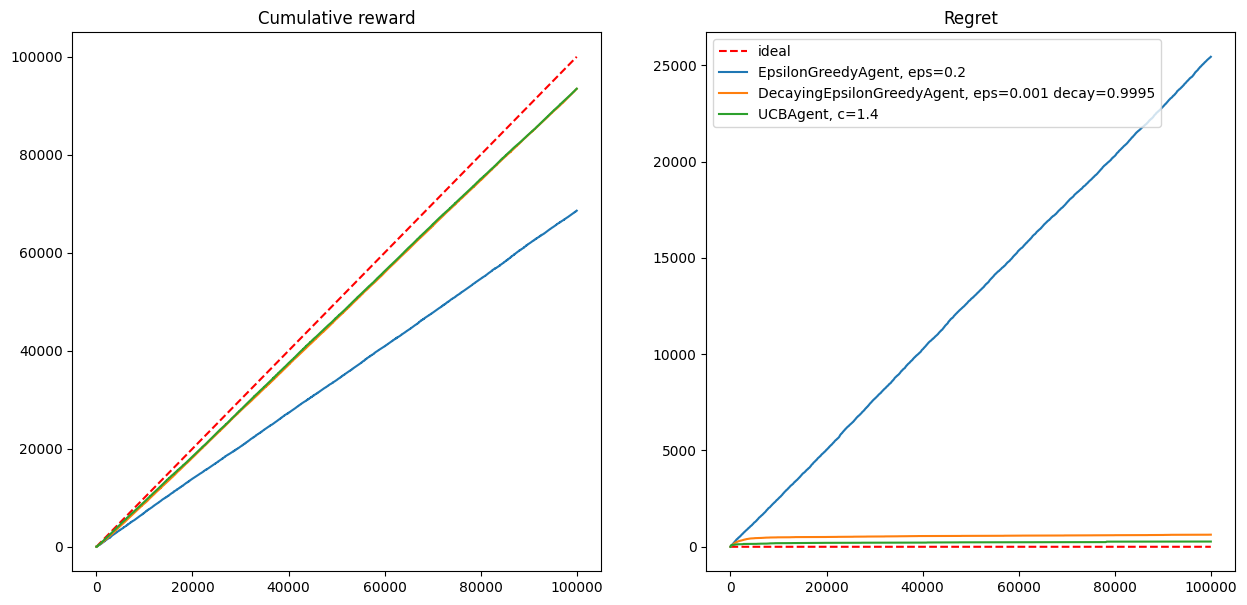

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
env = BanditTenArmedGaussian(seed=seed)
n_actions = env.action_space.n
n_trials = 100000
xs = np.arange(1, n_trials+1)
eps, eps_decay, exp_const = .2, .9995, .001
c = 1.4

# Evaluate and plot results for rand, eps-greedy, eps-greedy w/ decay and ucb agents
####### Здесь ваш код ########
def run_experiment(env:BanditEnv,
                   algorithm: Agent,
                   steps):
    reward_history = []
    regret_history = []

    for n_step in steps:
        action = algorithm.act()
        _, reward, done, info = env.step(action)
        algorithm.update(action, reward)
        reward_history.append(reward)
        regret_history.append(info["regret"])
    
    reward_history = np.cumsum(reward_history)
    regret_history = np.cumsum(regret_history)
    return reward_history, regret_history

algorithms = [
    EpsilonGreedyAgent(n_actions, seed, eps),
    DecayingEpsilonGreedyAgent(n_actions, seed, eps, eps_decay, exp_const),
    UCBAgent(n_actions, seed, c)]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax1 = axes[0]
ax1.set_title("Cumulative reward")
ax1.plot(xs, xs, "--r", label="ideal")
ax2 = axes[1]
ax2.set_title("Regret")
ax2.plot(xs, np.zeros_like(xs), "--r", label="ideal")

for algorithm in algorithms:
    reward_history, regret_history = run_experiment(env, algorithm, xs)
    ax1.plot(xs, reward_history, label=str(algorithm))
    ax2.plot(xs, regret_history, label=str(algorithm))
    plt.legend()

##############################

## Контекстные бандиты (Online Contextual Bandits)

### Описание задачи

Контекстные бандиты служат для решения проблемы, аналогичной многоруким бандитам, с той лишь разницей, что на каждой итерации выбора действия есть дополнительная информация.
 
Задача может быть описана итеративным процессом получения данных:

* На каждой итерации среда генерирует наблюдение, которое состоит из вектора признаков фиксированного размера, и значение вознаграждения, который является стохастичным, но зависит от первого вектора. 

* Агент должен выбрать одно действие из множества действий ("рук") $m$.

* Среда сообщает вознаграждение для руки, которую выбрал агент.

Цель - построить стратегию, которая будет максимизировать вознаграждение, получаемое агентом.

Примерами сценариев использования могут быть задачи онлайн рекомендаций, в которых есть лишь информация о том, нажал ли пользователь на рекламную ссылку или нет, а информации про другие ссылки, на которые он нажал - нет.

Или задачи клинических испытаний, в которых мы знаем, как человек отреагировал на одно лекарство, но не знаем, как он отреагировал бы на другое.

###  Алгоритмы

В данном пункте мы частично рассмотрим библиотеку [Contextual Bandits](https://github.com/david-cortes/contextualbandits)

Библиотека предлагает реализации большого списка алгоритмов:

* Upper-confidence bounds: `BootstrappedUCB`, `LogisticUCB`, и `LinUCB`.

* Thompson sampling: `BootstrappedTS`, `LogisticTS`, `LinTS`, and `SoftmaxExplorer`. 

* Greedy exploration: `EpsilonGreedy`

* Adaptive exploration: `AdaptiveGreedy`

Более полную информацию вы можете найти в [документации](https://contextual-bandits.readthedocs.io/en/latest/).
Также, обратите внимание на [примеры](https://github.com/david-cortes/contextualbandits/tree/master/example).


### Устанавливаем библиотеку и скачиваем данные

В данном случае используется датасет [Bibtex dataset](http://mlkd.csd.auth.gr/publication_details.asp?publicationID=278)  (см. _"Multilabel text classification for automated tag suggestion"_), содержащий теги, которые люди присвоили разным документам (цель - научиться предлагать теги на основе данных из этих документов). Скачать датасет можно на сайте: [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html).

In [20]:
!pip install -q contextualbandits 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM' -O bib.zip

--2023-04-09 17:37:36--  https://docs.google.com/uc?export=download&id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM
Resolving docs.google.com (docs.google.com)... 74.125.137.113, 74.125.137.102, 74.125.137.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vn4jcqagvnofj0muc5lpkilpehnk968/1681061850000/17883253590272791010/*/0B3lPMIHmG6vGcy1xM2pJZ09MMGM?e=download&uuid=41f9dbdf-9962-4a9c-ad01-61e9d2c01fc6 [following]
--2023-04-09 17:37:40--  https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vn4jcqagvnofj0muc5lpkilpehnk968/1681061850000/17883253590272791010/*/0B3lPMIHmG6vGcy1xM2pJZ09MMGM?e=download&uuid=41f9dbdf-9962-4a9c-ad01-61e9d2c01fc6
Resolving doc-0k-a0-docs.googleusercontent.com (doc-0k-a0-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
C

In [22]:
!unzip bib.zip

Archive:  bib.zip
  inflating: Bibtex/Bibtex_data.txt  
  inflating: Bibtex/bibtex_trSplit.txt  
  inflating: Bibtex/bibtex_tstSplit.txt  


### Считываем данные

Данные представляют собой текстовый файл, используемый в libsvm и других системах, но с первой строкой, указывающей количество строк, столбцов и классов:

In [23]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Bibtex/Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


## Пакетные модели

Логистическая регрессия и контекстный бандит:

In [24]:
from sklearn.linear_model import LogisticRegression

from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)


## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = 1111)


models = [bootstrapped_ucb]

In [25]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, *_ = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, ]

# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, *_ = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, ]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],
              warm_start = True)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)

### Визуализируем результаты

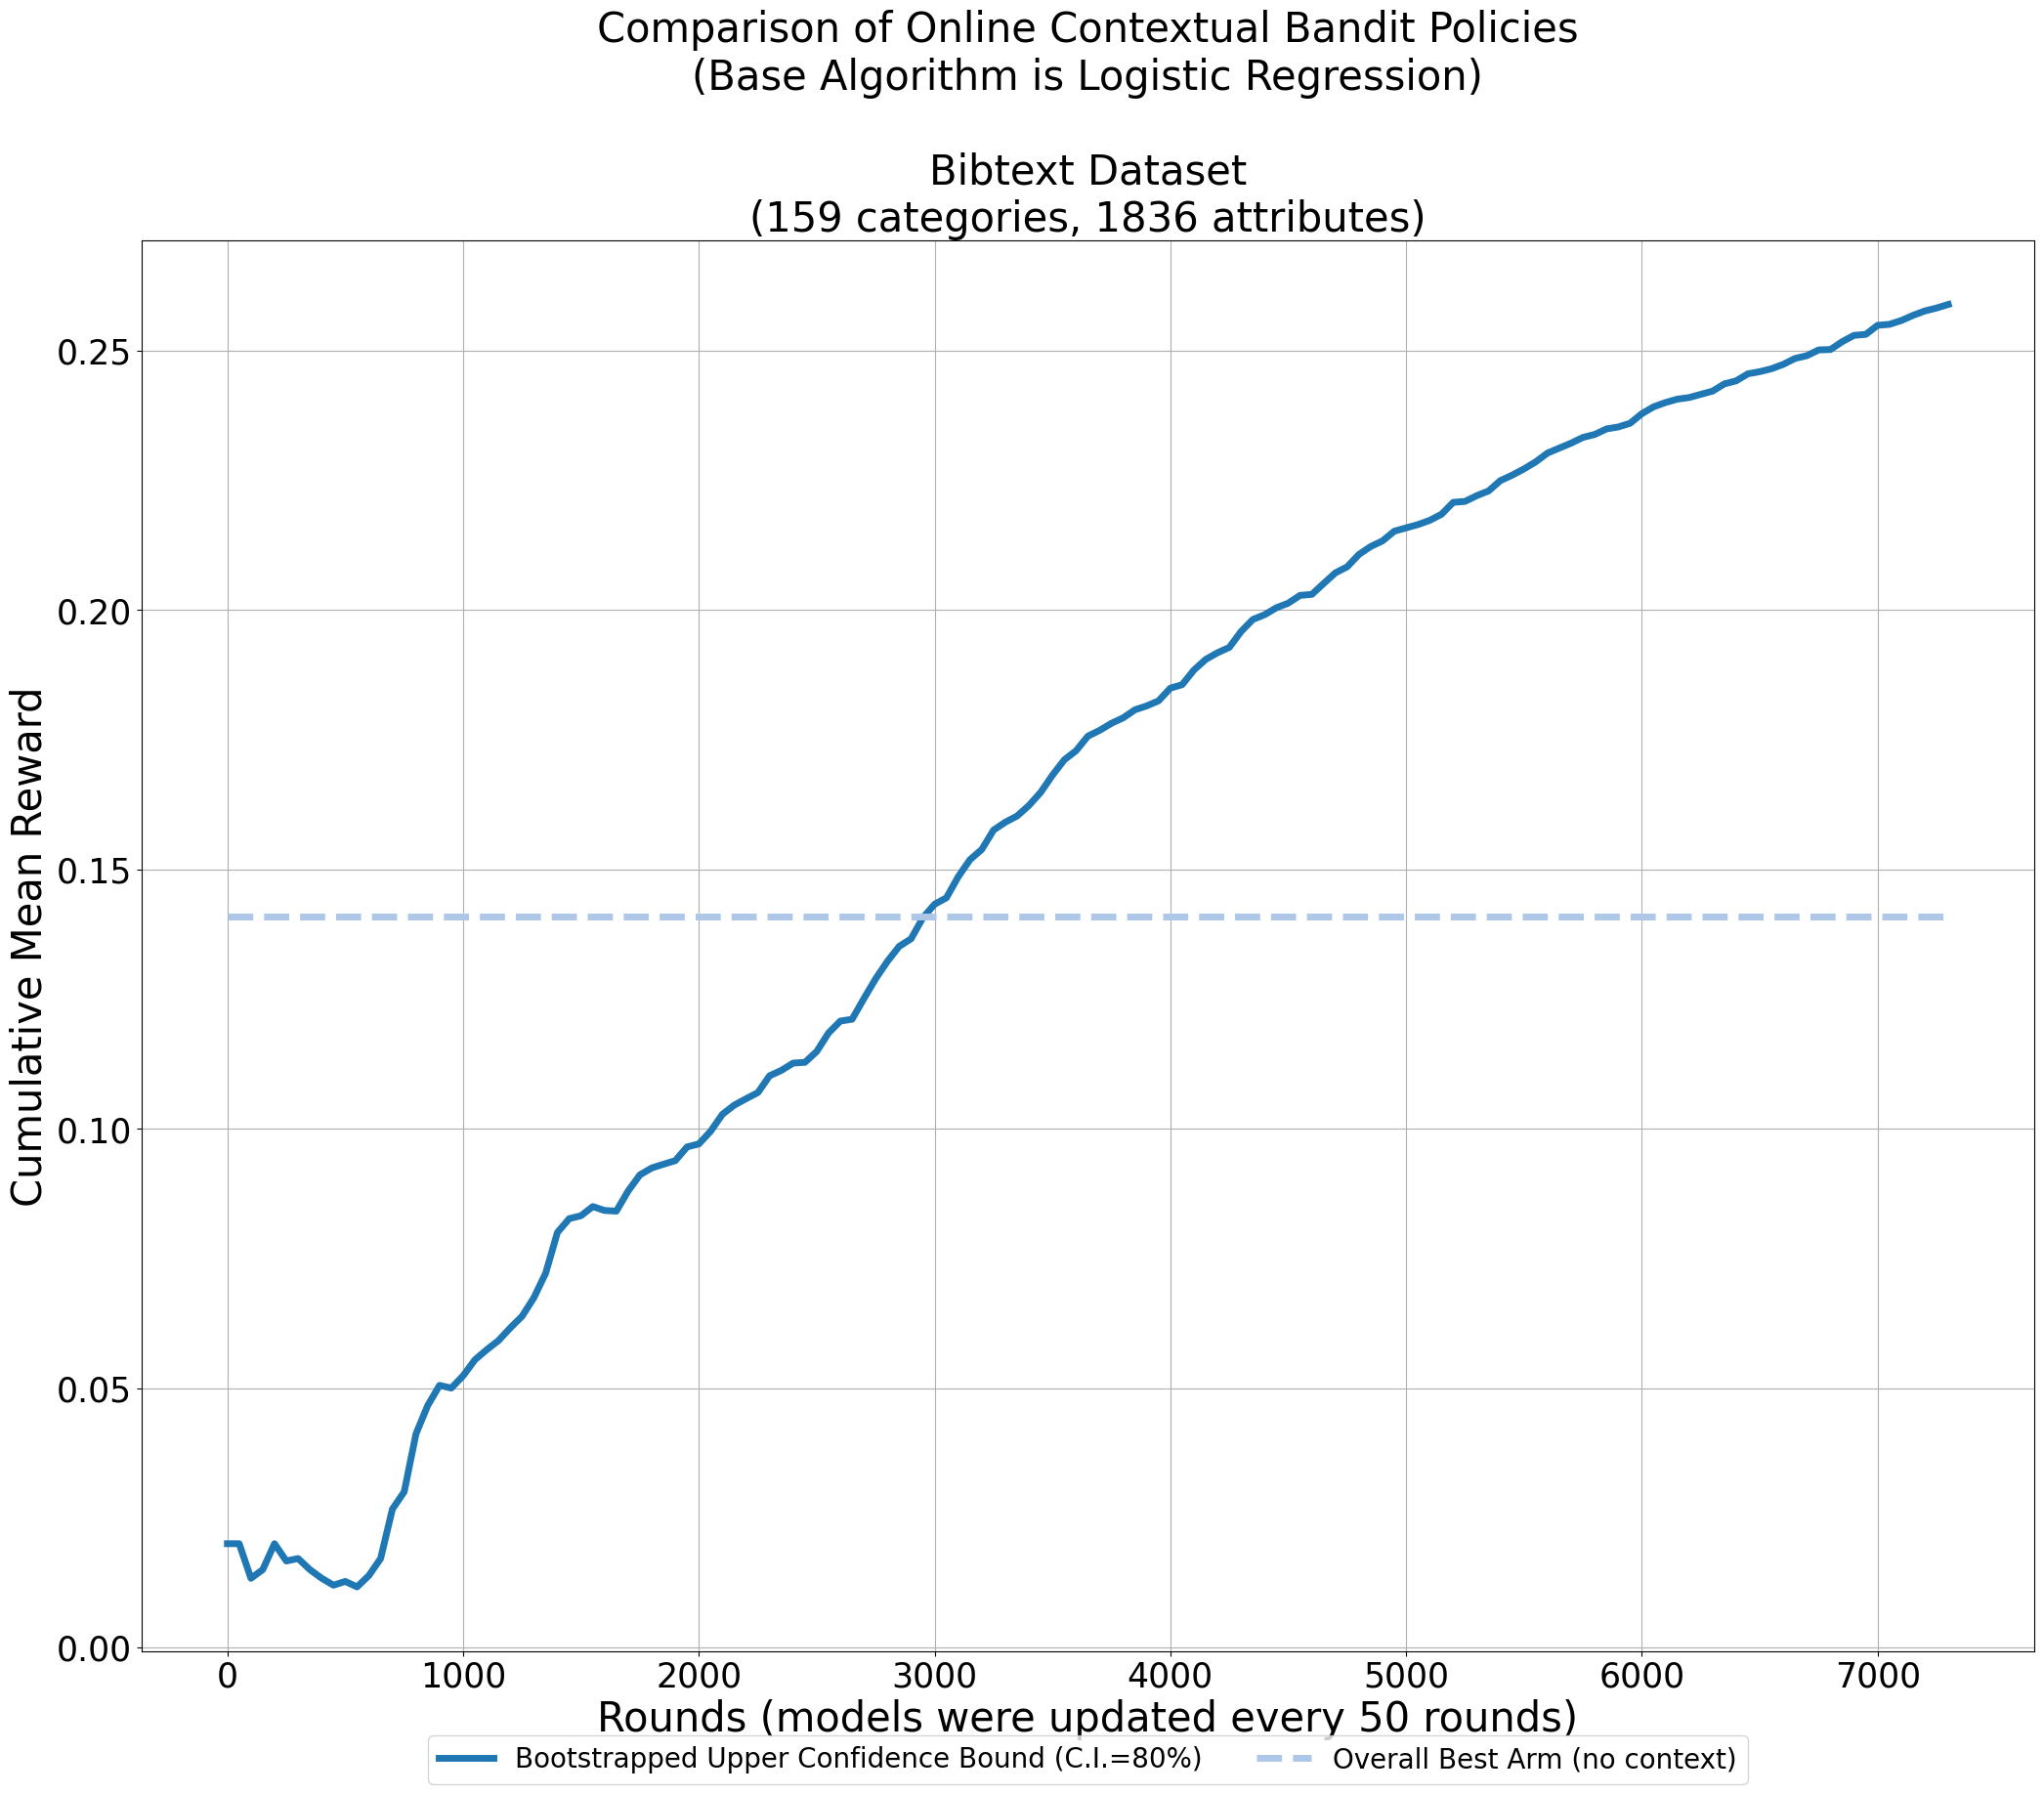

In [26]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])

plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_ucb)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()